In [105]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import numpy as np


In [106]:
class ForwardProcess:
  def __init__(self, image, timesteps, betas):
        self.image = image 

        # Step 1: define our timestep
        self.timesteps = timesteps

        # Step 2: define our variance schedule
        self.betas = betas 
        
        # step 3: define our random distribution
        # self.epislon = torch.normal(mean=0, std=1, size=image.shape)
        # self.epislon = torch.randn_like(image)

  def get_epislon(self):
    epislon = torch.randn_like(self.image)
    return epislon 
         

  def single_step(self, x_prev, t):
    """single step: xₜ = √(1-βₜ)xₜ₋₁ + √βₜε"""
    # Step 1: define β at timestep t
    beta_t = self.betas[t]
    # Step 2:  √(1-βₜ)xₜ₋₁, how much of the original image to keep after t steps
    remaining_image =  torch.sqrt(1-beta_t) * x_prev     
    # Step 3: √βₜε, how much noise to add -> randomly distributed            
    noise_t =  torch.sqrt(beta_t) * self.get_epislon()   
    # Step 4: Putting it all together                   
    xt =  remaining_image + noise_t
    return xt

  def all_steps(self):
    """apply the noise add over each timesteps, t"""
    x = [self.image]
    for t in range(self.timesteps):
      xt = self.single_step(x_prev=x[t], t=t)
      x.append(xt)
    return x

  def direct_sampling(self, t):
    """xₜ = √ᾱₜ x₀ + √(1-ᾱₜ) ε"""
    if t == 0:
       x = self.image
       return x
    # Step 1: define αₜ = 1 - βₜ
    alphas = 1 - self.betas 

    # Step 2: define ᾱₜ = ∏ˢ₌₁ᵗ αₛ
    alpha_cum_prod = torch.cumprod(alphas, dim=0)

    # Step 3: compute √ᾱₜ x₀
    sqrt_alpha_cum_product_t = torch.sqrt(alpha_cum_prod[t-1]).view(-1, 1, 1)    
    remaining_image = sqrt_alpha_cum_product_t * self.image

    # Step 4: compute √(1-ᾱₜ) ε
    one_minus_alpha_cum = torch.sqrt(1-alpha_cum_prod[t-1]).view(-1, 1, 1)
    noise = one_minus_alpha_cum * self.get_epislon()

    x = remaining_image + noise

    return x
  
  def get_schedule(self):
    schedules = {"betas" : self.betas,
                  "alphas" : 1 - self.betas}
    return schedules


In [107]:
# Get Image
img_path = "cat.jpg"
image = Image.open(img_path)
img_to_tensor = transforms.ToTensor()
image = img_to_tensor(image)                   # This is our x0
print(image.shape)


torch.Size([3, 401, 600])


In [108]:
# Plot nosified images
def plot(x, t, schedules):
    alphas= schedules["alphas"]
    betas = schedules["betas"]

    plt.figure(figsize=(20, 4)) 

    for i in range(len(t)):
        display_image = np.array(x[i])                      # convert tensor to numpy  
        display_image = display_image.transpose(1, 2, 0)    # change from (C, H, W) to (H, W, C)
        display_image = np.clip(display_image, 0, 1)        # clip image
        plt.subplot(1, len(t), i+1)
        plt.imshow(display_image)
        plt.axis('off') 
        plt.title(f'Step {t[i]}')
        # if i == 0:
        #     plt.title(f'Step {t[i]}')
        # else:
        #     plt.title(f'Step {t[i]} \nbeta {betas[i]:2f}, alpha {alphas[i]:2f}')

    plt.tight_layout() 
    plt.show() 
    return

In [109]:

def gaussian_pdf(x_axis_values, xt):
    """f(x,μ,σ²) = (1/√(2πσ²)) * e^(-(x-μ)²/2σ²)"""
    # Step 1: Calculate mean, std, and variance
    mean = np.mean(xt); std = np.std(xt); variance = np.square(std)

    # Step 2: Calculate the gaussian
    first_part = (1 / np.sqrt(2 * np.pi * variance))
    second_part_power = -np.square(x_axis_values-mean) / (2 * variance)
    second_part = np.exp(second_part_power)
    gaussian =  first_part * second_part
    return gaussian, mean, std

def plot_dis(xs, t):
    plt.figure(figsize=(20, 4)) 
    for i in range(len(t)):
        # Step 1: Convert to numpy and Flatten image
        xt = np.array(xs[i])
        xt = xt.flatten()

        # Step 2: Create x-axis values for the Gaussian plot
        x_axis_values = np.linspace(np.min(xt), np.max(xt), xt.shape[0])

        # Step 3: Calculate Guassian Distribution
        gaussian, mean, std = gaussian_pdf(x_axis_values=x_axis_values, xt=xt)

        # Step 4: Plot histogram of data and Gaussian PDF
        plt.subplot(1, len(t), i+1)
        plt.hist(xt, bins=30, density=True, alpha=0.5)
        plt.plot(x_axis_values, gaussian, 'r')

        plt.title(f'Step {t[i]}, \nmean {mean:.2f}, std {std:.2f}')
    
    plt.show()
    

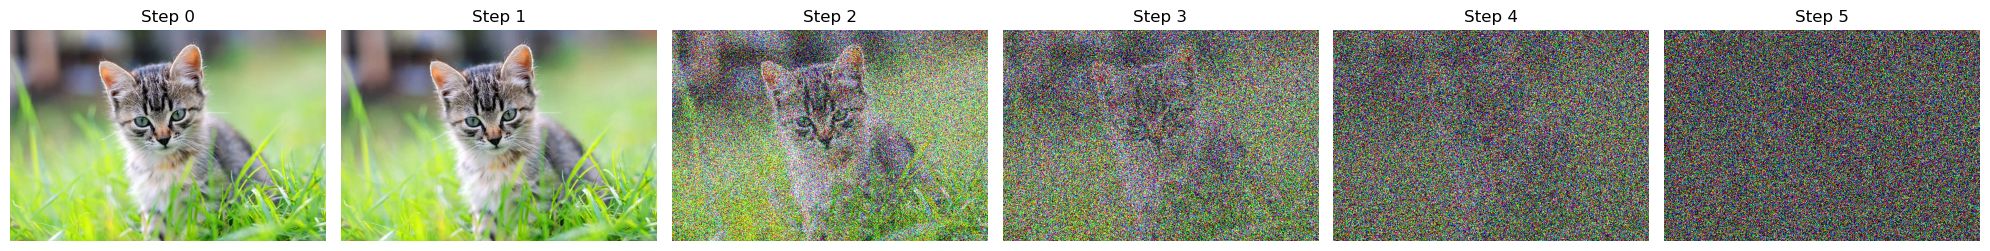

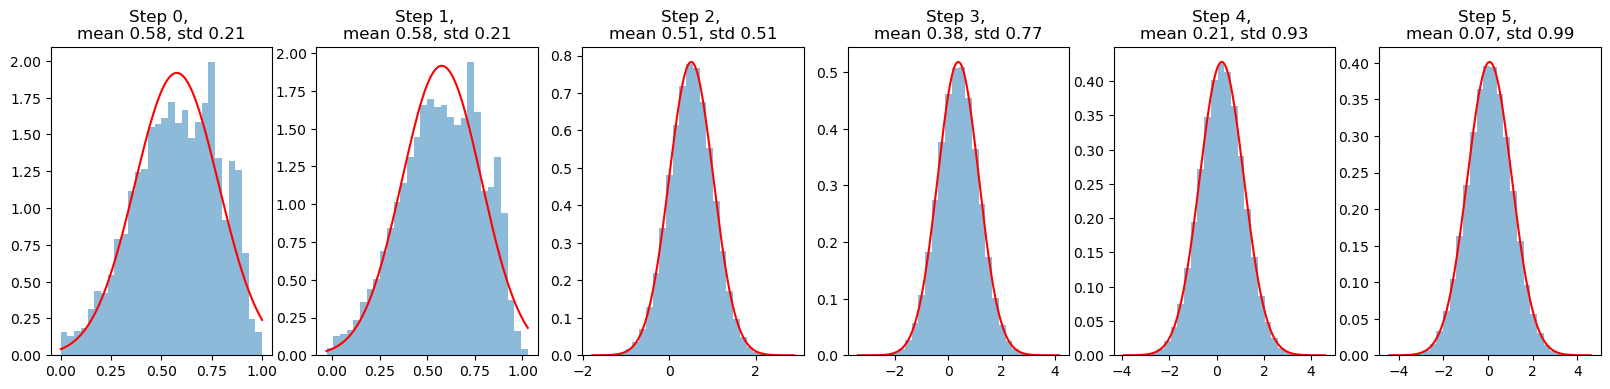

In [110]:
timesteps = 5
# betas = torch.linspace(start=0.0001, end=0.02, steps=timesteps)
betas = torch.linspace(start=0.0001, end=0.9, steps=timesteps)
fp = ForwardProcess(timesteps=timesteps, image=image, betas=betas)
x = fp.all_steps()
schedules = fp.get_schedule()

t = list(range(timesteps+1)) if timesteps <= 5 else [0, 1, 5, timesteps]
plot(x=x, t=t, schedules=schedules)
plot_dis(xs=x, t=t)

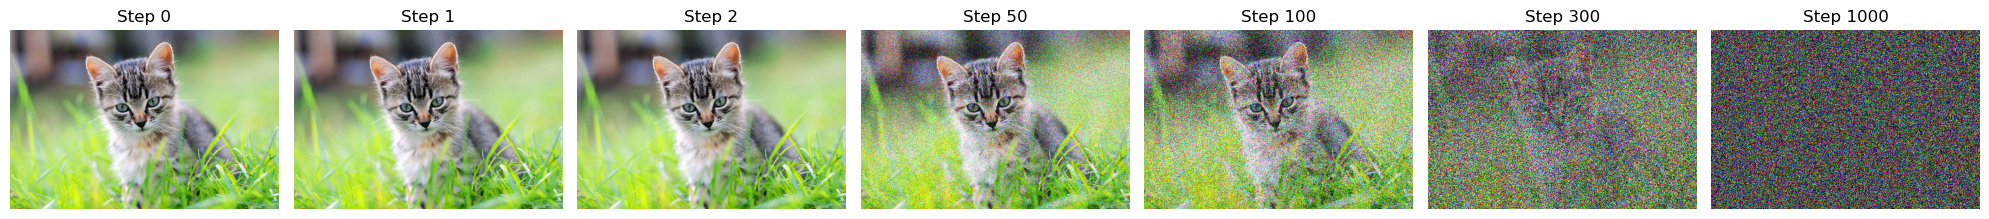

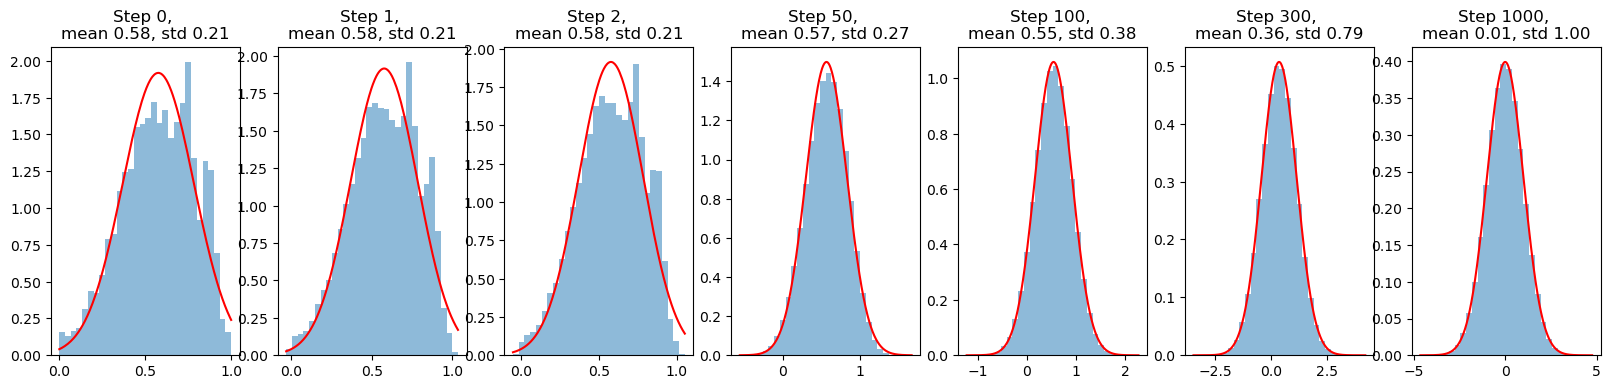

In [111]:
timesteps = 1000
betas = torch.linspace(start=0.0001, end=0.02, steps=timesteps)
fp = ForwardProcess(timesteps=timesteps, image=image, betas=betas)
x=[]
intervals = [0, 1, 2, 50, 100, 300, 1000]
for t in intervals:
    xt = fp.direct_sampling(t=t)
    x.append(xt)
schedules = fp.get_schedule() 
plot(x=x, t=intervals, schedules=schedules)
plot_dis(xs=x, t=intervals)

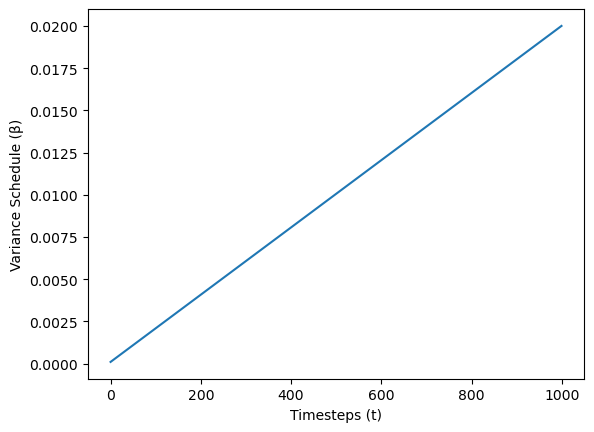

In [112]:
# plot betas
betas = schedules["betas"]
betas = np.array(betas)

plt.plot(betas, label="betas")
plt.xlabel('Timesteps (t)')
plt.ylabel('Variance Schedule (β)')
# plt.grid()
plt.show()


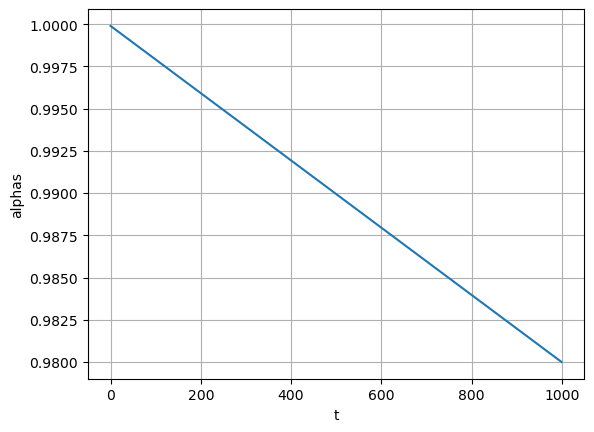

In [113]:
alphas = schedules["alphas"]
alphas = np.array(alphas)
plt.plot(alphas, label="alphas")

plt.xlabel('t')
plt.ylabel('alphas')
plt.grid()
plt.show()